In [2]:
import pandas as pd
import numpy as np
import scipy.stats as si
import sympy as sy
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
os.chdir('C:/Users/regru/Desktop/Datasets')
#import dataset
df0 = pd.read_csv('loan.csv',low_memory=False)
#remove columns that won't be used
df0 = df0.drop(['url','id','member_id'],axis=1)
#get pct of NaN values in each column to decide which cols to drop
df0.isna().mean()
#np.sum(list(df0.isna().mean() < .5))
#if NaN is > 50% then drop column
df1 = df0.dropna(axis=1,thresh=.5*len(df0))
#orignial df has 71 columns
len(df0.columns.tolist())
#dropped 21 columns that contained 50% or more NaN. now df has 50 
len(df1.columns.tolist())
#replace NaN with median for all integer columns
#create list of all int columns to use to replace NaN
is_numeric = np.vectorize(lambda x: np.issubdtype(x, np.number))
NaN_col = list(df1.columns[is_numeric(df1.dtypes)])
#fill in median value for all NaN's in numeric columns
pd.options.mode.chained_assignment = None 
df_numerics = df1.loc[:,NaN_col].fillna(df1.median()).copy()
df1.loc[:,NaN_col] = df_numerics
df = df1
#calc total pymnt owed = installment*term
#strip out number of months from term
def strip_int(string):
    """removes numbers from string with numbers and letters. converts numbers"""
    """into type int"""
    num = np.zeros(len(string))
    for s in range(len(string)):
        num[s] =  int(float(''.join(i for i in string[s] if i.isnumeric())))
    return(num)
terms = strip_int(df['term'])   
#replace term column with just numbers
df['term_int'] = terms
df['undisc_total_due'] = df['installment']*df['term_int']
#pct of each loan status group
df['loan_status'].value_counts().sort_index() / len(df)
#goal is to predict late delinquent or worse status i.e. not fully paid or current
#create new indicator late,default,charged off,grace period in one group and fully paid and current in another
paid_up = ['Current','Fully Paid']
#indicator shows 1 if current or fully paid and 0 if late or anything worse
df['paid_unpaid_ind'] = [1 if status in paid_up else 0 for status in df['loan_status']]
#pct of delinquent or worse loans
df['paid_unpaid_ind'].mean()
#create column issue_year
df['issue_year'] = strip_int(df['issue_d'])

Question 1: Can you count something interesting?

In [3]:
#pct of people in each credit rating, B has the most with 28%
100*df.groupby('grade')['grade'].count()/len(df)

grade
A    16.701094
B    28.683911
C    27.706313
D    15.725186
E     7.967847
F     2.597086
G     0.618563
Name: grade, dtype: float64

In [4]:
#pct of people in each purpose group, debt consolidation is the most common at 59%
100*df.groupby('purpose')['purpose'].count()/len(df)

purpose
car                    0.998784
credit_card           23.234942
debt_consolidation    59.074533
educational            0.047668
home_improvement       5.840684
house                  0.417747
major_purchase         1.946970
medical                0.962385
moving                 0.610111
other                  4.833786
renewable_energy       0.064798
small_business         1.169399
vacation               0.533707
wedding                0.264487
Name: purpose, dtype: float64

Question 2: Can you find trends (e.g. high, low, increasing, decreasing, anomalies)?

In [8]:
#paid rate has consistently gotten better from 2007 to 2015. 
paid_rate_by_year = df.groupby('issue_year')['paid_unpaid_ind'].agg('mean')
paid_rate_by_year

issue_year
2007.0    0.341625
2008.0    0.549519
2009.0    0.780534
2010.0    0.801228
2011.0    0.848165
2012.0    0.841775
2013.0    0.865719
2014.0    0.905117
2015.0    0.951182
Name: paid_unpaid_ind, dtype: float64

In [9]:
#although the paid rate has gotten better the dti has gotten worse from 2007 to 2015
dti_by_year = df.groupby('issue_year')['dti'].agg('mean')
dti_by_year

issue_year
2007.0    10.709519
2008.0    13.204605
2009.0    12.466548
2010.0    13.095154
2011.0    13.846331
2012.0    16.661354
2013.0    17.216032
2014.0    18.040782
2015.0    19.196014
Name: dti, dtype: float64

In [10]:
#avg number of open credit accounts has been increasing from 2007 to 2015
acc_by_year = df.groupby('issue_year')['open_acc'].agg('mean')
acc_by_year

issue_year
2007.0     8.686567
2008.0     9.734643
2009.0     9.289339
2010.0     9.249501
2011.0     9.389163
2012.0    10.622370
2013.0    11.150963
2014.0    11.668104
2015.0    11.948629
Name: open_acc, dtype: float64

Question 3: Can you make a bar plot or a histogram?

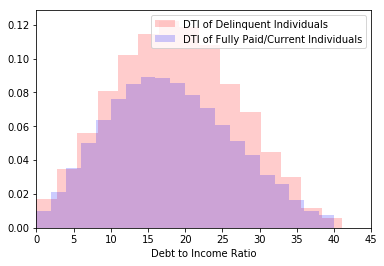

In [11]:
#hist of debt to income ratios for charged off and fully paid groups
dti_delinq = df.dti[df['paid_unpaid_ind'] == 0]
dti_full_paid = df.dti[df['paid_unpaid_ind'] == 1]
plt.hist(dti_delinq,weights=np.zeros_like(dti_delinq) + 1. / dti_delinq.size,color='red',bins=50, alpha=.2)
plt.hist(dti_full_paid,weights=np.zeros_like(dti_full_paid) + 1. / dti_full_paid.size,color='blue',bins=5000, alpha=.2)
plt.xlabel('Debt to Income Ratio')
plt.xlim(0,45)
plt.legend(['DTI of Delinquent Individuals','DTI of Fully Paid/Current Individuals'])
plt.show()

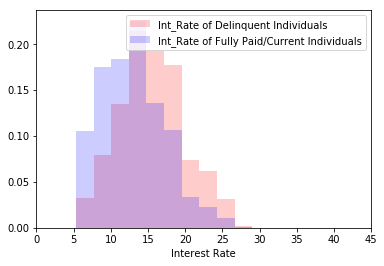

In [12]:
#hist of interest rate for charged off and fully paid groups
rate_delinq = df.int_rate[df['paid_unpaid_ind'] == 0]
rate_full_paid = df.int_rate[df['paid_unpaid_ind'] == 1]
plt.hist(rate_delinq,weights=np.zeros_like(rate_delinq) + 1. / rate_delinq.size,color='red',bins=10, alpha=.2)
plt.hist(rate_full_paid,weights=np.zeros_like(rate_full_paid) + 1. / rate_full_paid.size,color='blue',bins=10, alpha=.2)
plt.xlabel('Interest Rate')
plt.xlim(0,45)
plt.legend(['Int_Rate of Delinquent Individuals','Int_Rate of Fully Paid/Current Individuals'])
plt.show()

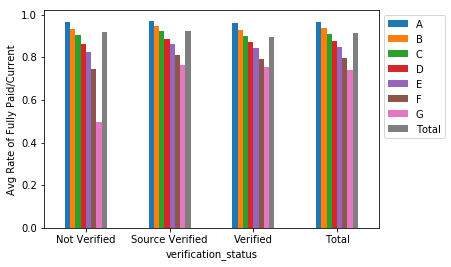

In [13]:
tab_verification = pd.pivot_table(df,values='paid_unpaid_ind',index='verification_status',columns='grade', aggfunc=np.mean, fill_value=0, margins=True, margins_name = "Total")
#plot of avg dti pivot table
tab_verification.plot(kind='bar')#.set_xticklabels( ('Delinquent', 'Fully Paid/Current','Total') )
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Avg Rate of Fully Paid/Current')
plt.xticks(rotation=0)
plt.show()

Question 4: Can you compare two related quantities?

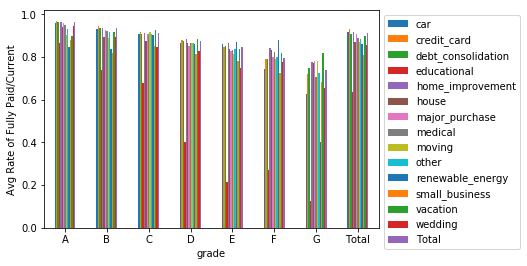

In [14]:
#pivot on grade and purpose
#paid off rate for people of most all purposes shows a strong relationship with credit rating as expected
tab_rate_purp = pd.pivot_table(df,values='paid_unpaid_ind',index='grade',columns='purpose', aggfunc=np.mean, fill_value=0, margins=True, margins_name = "Total")
tab_rate_purp.plot(kind='bar')#.set_xticklabels( ('Delinquent', 'Fully Paid/Current','Total') )
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Avg Rate of Fully Paid/Current')
plt.xticks(rotation=0)
plt.show()

In [15]:
#however for renewable_energy the paid rate shows no distinguishable relationship with credit rating with the exception of the lowest rating G
tab_rate_purp['renewable_energy']

grade
A        0.847458
B        0.838710
C        0.902778
D        0.861111
E        0.869048
F        0.878049
G        0.400000
Total    0.860870
Name: renewable_energy, dtype: float64

Question 5: Can you make a scatterplot?

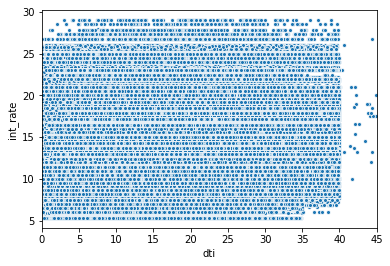

In [16]:
#a scatterplot with debt to income ratio and interest rate shows no distinguishable relationship
sns.scatterplot(x=df['dti'],y=df['int_rate'],s=15)
plt.xlim(0,45)
plt.show()

Question 6: Can you make a time-series plot?

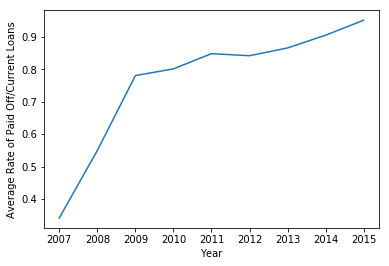

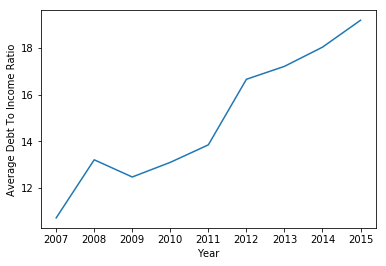

In [20]:
#paid rate by year shows the increasing trend in avg paid rates each year
plt.plot(paid_rate_by_year)
plt.xlabel('Year')
plt.ylabel('Average Rate of Paid Off/Current Loans')
plt.show()
#dti by year shows the increasing trend in avg dti by year
plt.plot(dti_by_year)
plt.xlabel('Year')
plt.ylabel('Average Debt To Income Ratio')
plt.show()

Question 7: Looking at the plots, what are some insights you can make? 
-The average rate of people who are either current in payments or paid off there loan has increased each year since 2007

                Do you see any correlations?
-There is a correlation between paid off rate and credit rating, across all groups, the better the credit rating the 
the higher the paid off rate.
                
                Is there a hypothesis you’d like to investigate further?
-Does higher interest rate lead to higher delinquency rate?

                What other questions do the insights lead you to ask?
-Is it safe to believe that for people who get a loan for renewable_energy purposes maintain the same paid rate across credit ratings with the exception of the lowest rating G?
                
-Do extremely high interest rates lead to high default rate or are those people extremely unlikely to pay and therefore get charged a higher rate?